# Competition Solution: Кредитный скоринг

# Решение тестовго технического задания от SHIFT

## Задача бинарной классификации с метрикой ROC-AUC

## 1. Импорт библиотек и настройка

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

# Модели
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.calibration import CalibratedClassifierCV

# Ансамбли
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier

# Дополнительные
from datetime import datetime
import joblib
import zipfile
import os

# Настройки
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

RANDOM_STATE = 42

print("Все библиотеки успешно импортированы!")

Все библиотеки успешно импортированы!


## 2. Загрузка данных

In [2]:
print("Загрузка данных...")
train = pd.read_csv('../data/shift_ml_2026_train.csv')
test = pd.read_csv('../data/shift_ml_2026_test.csv')

print(f"Размер train: {train.shape}")
print(f"Размер test: {test.shape}")

Загрузка данных...
Размер train: (1210779, 109)
Размер test: (134531, 108)


### Первичный осмотр

In [3]:
print("\nПервые 5 строк train:")
display(train.head())


Первые 5 строк train:


,id,сумма_займа,срок_займа,процентная_ставка,аннуитет,рейтинг,допрейтинг,профессия_заемщика,стаж,владение_жильем,годовой_доход,подтвержден_ли_доход,итоговый_статус_займа,рейтинг_OCR,платежный_график,коэфф_акционных_зачислений_в_остатке,цель_займа,кол_во_субсидий_за_год,индекс_проживания,регион,пдн,пос_стоп_фактор,юридический_статус,кол-во_просрочек_за_два_года,коэфф_невыплаченного_сумм_остатка,коэфф_исходного_платежа,дата_первого_займа,нижний_порог_рейтинга_заемщика,верхний_порог_рейтинга_заемщика,кол-во_заявок_за_полгода,кол-во_месяцев_с_последней_просрочки,кол-во_месяцев_с_последнего_займа,кол-во_открытых_счетов,кол-во_записей_в_общедоступных_документах,оборотный_баланс,коэфф_загрузки_возобновляемого_счета,кол-во_счетов,первоначальный_статус_займа,непогашенная_сумма_из_тела_займов,сумма_выплат_по_просрочкам,пени_за_дефолт,дата_следующей_выплаты,грейд_на_детерминаторе,кол-во_взысканий_за_последний_год,кол-во_месяцев_с_последнего_нарушения,код_политики,тип_займа,совокупный_доход_заемщиков,совокупный_пдн_заемщиков,совокупный_статус_подтверждения_доходов_заемщиков,кол-во_текущих_просроченных_счетов,общая_сумма_взысканий,возвраты_с_учетом_мпл,общая_сумма_на_счетах,кол-во_открытых_счетов_за_полгода,кол-во_текущих_аннуитетных_счетов,кол-во_аннуитетных_счетов_за_год,кол-во_аннуитетных_счетов_за_2_года,кол-во_месяцев_с_посл_аннуитетного_счета,текущий_баланс_по_аннуитетным_счетам,соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам,кол-во_возоб_счетов_за_год,кол-во_возоб_счетов_за_2_года,макс_баланс_по_возоб_счетам,соотношение_баланса_к_лимиту_общее,общий_лимит_по_возоб_счету,кол-во_финансовых_запросов,кол-во_финансовых_операций,кол-во_заявок_на_кредит_за_год,кол-во_открытых_счетов_за_2_года,средний_баланс_текущих_счетов,суммарная_доступная_сумма_займа_по_картам,соотношение_баланса_к_лимиту_по_картам,кол-во_списаний_за_год,сумма_задолженности,кол-во_месяцев_с_первого_аннуитетного_счета,кол-во_месяцев_с_первого_возобновляемого_счета,кол-во_месяцев_с_последнего_возобновляемого_счета,кол-во_месяцев_с_последнего_счета,кол-во_ипотек,кол-во_месяцев_с_последней_карты,кол-во_мес_с_последней_задолженности_по_карте,кол-во_мес_с_последней_заявки,кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,кол-во_счетов_с_просрочкой_4_мес,кол-во_активных_карт,кол-во_активных_возобновляемых_счетов,кол-во_карт_без_нарушений,кол-во_карт,кол-во_аннуитетных_счетов,кол-во_открытых_возобновляемых_счетов,кол-во_возобновляемых_счетов,кол-во_возобновляемых_счетов_с_балансом_более_0,кол-во_счетов_без_нарушений,кол-во_счетов_с_акт_просрочкой_4_мес_обн_2_мес,кол-во_счетов_с_акт_просрочкой_1_мес,кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года,кол-во_счетов_за_посл_год,процент_счетов_без_просрочек,процент_счетов_прев_75_лимита,кол-во_публ_банкротств,кол-во_залогов,кредитный_лимит,кредитный_баланс_без_ипотеки,лимит_по_картам,лимит_по_аннуитетным_счетам,кредитный_баланс_по_возоб_счетам,особая_ситуация,тип_предоставления_кредита
0,68355089,1235000.000,3 года,11.990,41014.000,В,В1,инженер,10+ лет,ИПОТЕКА,1300000.000,Не подтвержден,0,4,n,0.899,мелкий_бизнес,0,577.000,Новгородская область,16.060,Нет,Нет,1.000,1345311.538,0.767,12-1999,715.000,719.000,4.000,6.000,NaN,22.000,0.000,21470.000,19.200,38.000,а,0.000,0.000,False,NaN,5,0.000,NaN,1.000,Индивидуальный,NaN,NaN,NaN,0.000,0.000,12213,10219800.000,1.000,1.000,0.000,1.000,19.000,900250.000,73.000,2.000,3.000,6472.000,29.000,5590000.000,0.000,0.000,6.000,4.000,486650.000,2891500.000,27.100,0.000,0.000,113.000,192.000,2.000,2.000,4.000,2.000,NaN,0.000,6.000,0.000,5.000,5.000,13.000,17.000,6.000,20.000,27.000,5.000,22.000,0.000,0.000,0.000,2.000,97.400,7.700,0.000,0.000,15700850.000,1973750.000,3965000.000,1233350.000,NaN,Нет,Наличные
1,68341763,1000000.000,5 лет,10.780,21633.000,Б,Б4,водитель грузовика,10+ лет,ИПОТЕКА,1260000.000,Не подтвержден,0,2,n,0.490,улучшение_жилищных_условий,0,605.000,Республика Татарстан,10.780,Нет,Нет,0.000,1345311.538,0.230,8-2000,695.000,699.000,0.000,NaN,NaN,6.000,0.000,7869.

In [4]:
print("\nИнформация о данных train:")
train.info()


Информация о данных train:
<class 'pandas.DataFrame'>
RangeIndex: 1210779 entries, 0 to 1210778
Columns: 109 entries, id to тип_предоставления_кредита
dtypes: float64(84), int64(6), object(1), str(18)
memory usage: 1006.9+ MB


## 3. EDA - Анализ данных

### Анализ целевой переменной

In [5]:
target_col = 'итоговый_статус_займа'
print(f"\nРаспределение целевой переменной '{target_col}':")
target_dist = train[target_col].value_counts(normalize=True)
print(target_dist)


Распределение целевой переменной 'итоговый_статус_займа':
итоговый_статус_займа
0   0.800
1   0.200
Name: proportion, dtype: float64


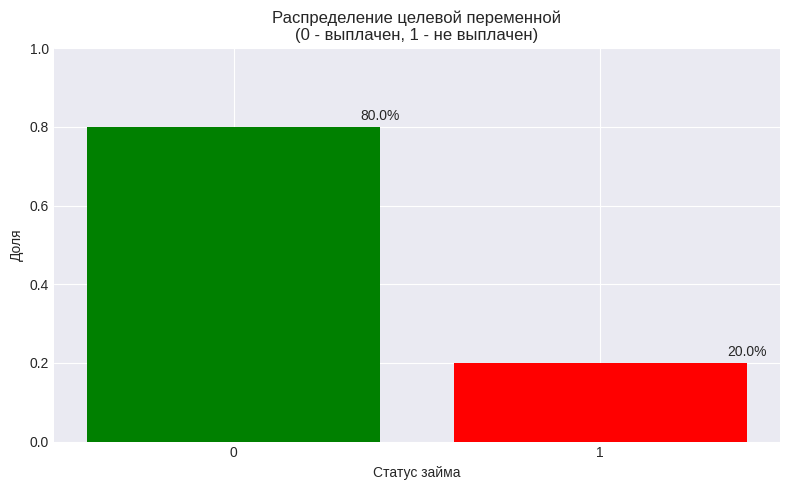

In [6]:
plt.figure(figsize=(8, 5))
bars = plt.bar(target_dist.index.astype(str), target_dist.values, color=['green', 'red'])
plt.title('Распределение целевой переменной\n(0 - выплачен, 1 - не выплачен)')
plt.xlabel('Статус займа')
plt.ylabel('Доля')
plt.ylim(0, 1)
for bar, value in zip(bars, target_dist.values):
    plt.text(bar.get_x() + bar.get_width(), bar.get_height() + 0.01, 
             f'{value:.1%}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

### Анализ пропусков

In [ ]:
print("\nАнализ пропусков в данных:")

def analyze_missing(df, dataset_name):
    missing = df.isnull().sum()
    missing_pct = (missing / len(df)) * 100
    missing_df = pd.DataFrame({
        'missing_count': missing,
        'missing_percent': missing_pct
    }).sort_values('missing_percent', ascending=False)
    
    missing_df = missing_df[missing_df['missing_count'] > 0]
    
    print(f"\n{dataset_name} - колонки с пропусками ({len(missing_df)}):")
    if len(missing_df) > 0:
        display(missing_df.head(20))
        if len(missing_df) > 0:
            plt.figure(figsize=(12, 6))
            missing_df.head(20)['missing_percent'].plot(kind='bar')
            plt.title(f'Топ-20 признаков с пропусками ({dataset_name})')
            plt.ylabel('Процент пропусков')
            plt.xticks(rotation=45, ha='right')
            plt.tight_layout()
            plt.show()
    else:
        print("Пропусков нет!")
    return missing_df


Анализ пропусков в данных:



Train - колонки с пропусками (69):


,missing_count,missing_percent
дата_следующей_выплаты,1210779,100.000
кредитный_баланс_по_возоб_счетам,1193971,98.612
совокупный_статус_подтверждения_доходов_заемщиков,1187729,98.096
совокупный_пдн_заемщиков,1187548,98.081
совокупный_доход_заемщиков,1187546,98.081
кол-во_месяцев_с_последнего_займа,1005117,83.014
кол-во_мес_с_последней_задолженности_по_карте,923517,76.275
кол-во_месяцев_с_последнего_нарушения,892120,73.681
кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,805599,66.536
соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам,792391,65.445


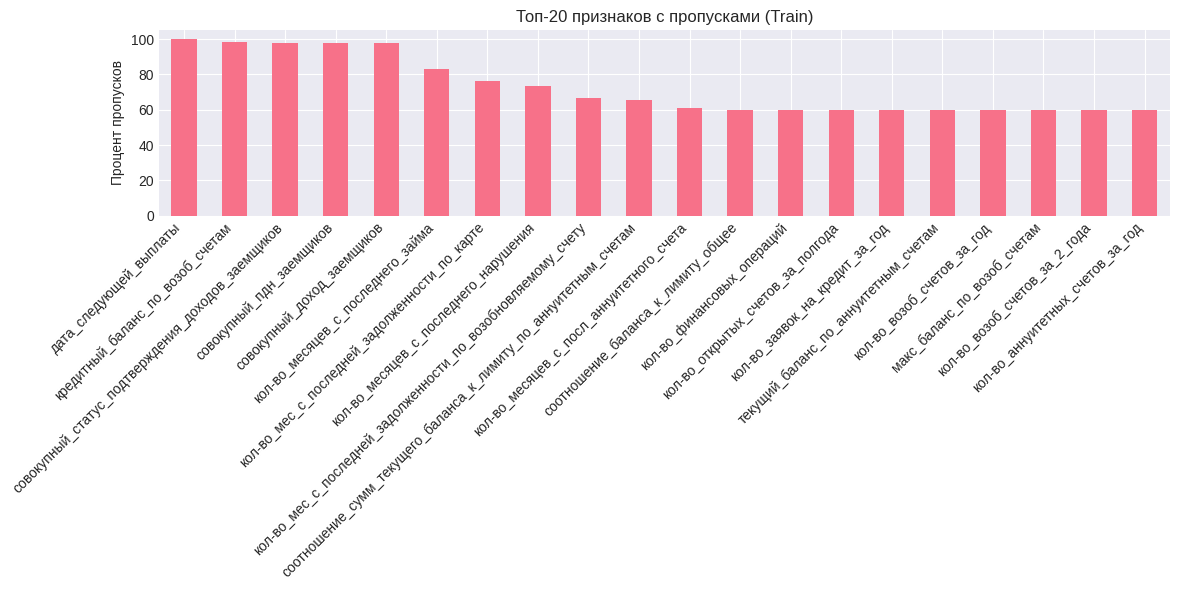

,missing_count,missing_percent
дата_следующей_выплаты,1210779,100.000
кредитный_баланс_по_возоб_счетам,1193971,98.612
совокупный_статус_подтверждения_доходов_заемщиков,1187729,98.096
совокупный_пдн_заемщиков,1187548,98.081
совокупный_доход_заемщиков,1187546,98.081
кол-во_месяцев_с_последнего_займа,1005117,83.014
кол-во_мес_с_последней_задолженности_по_карте,923517,76.275
кол-во_месяцев_с_последнего_нарушения,892120,73.681
кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,805599,66.536
соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам,792391,65.445


In [9]:
missing_train = analyze_missing(train, 'Train')
missing_train


Test - колонки с пропусками (67):


,missing_count,missing_percent
дата_следующей_выплаты,134531,100.000
пени_за_дефолт,134531,100.000
кредитный_баланс_по_возоб_счетам,132710,98.646
совокупный_статус_подтверждения_доходов_заемщиков,131986,98.108
совокупный_пдн_заемщиков,131965,98.093
совокупный_доход_заемщиков,131964,98.092
кол-во_месяцев_с_последнего_займа,111638,82.983
кол-во_мес_с_последней_задолженности_по_карте,102773,76.394
кол-во_месяцев_с_последнего_нарушения,99440,73.916
кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,89749,66.713


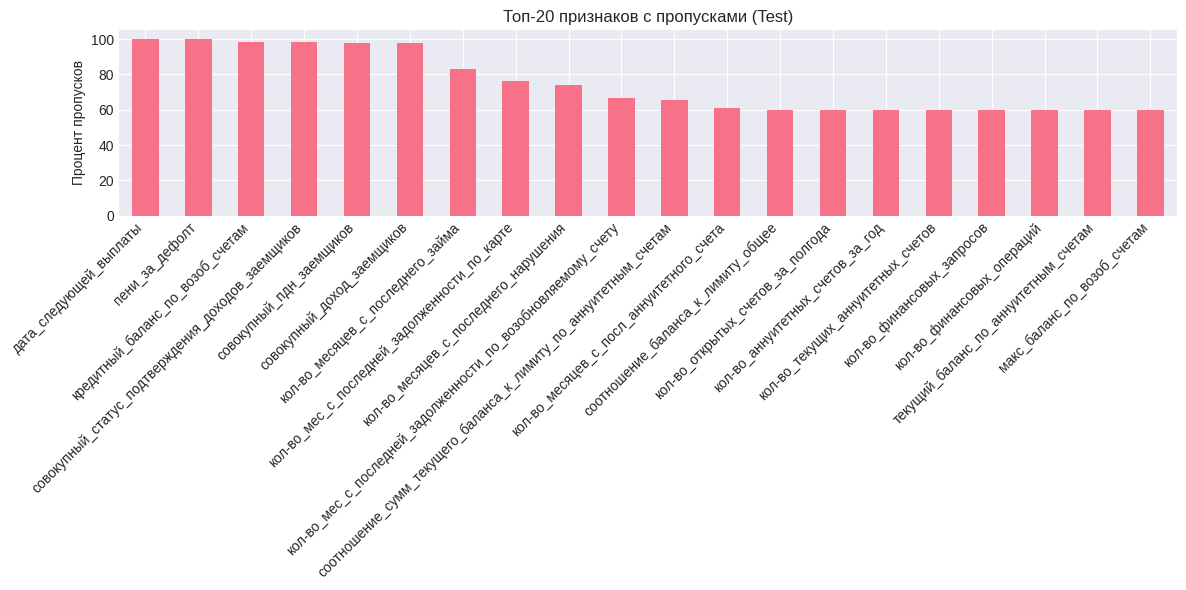

,missing_count,missing_percent
дата_следующей_выплаты,134531,100.000
пени_за_дефолт,134531,100.000
кредитный_баланс_по_возоб_счетам,132710,98.646
совокупный_статус_подтверждения_доходов_заемщиков,131986,98.108
совокупный_пдн_заемщиков,131965,98.093
совокупный_доход_заемщиков,131964,98.092
кол-во_месяцев_с_последнего_займа,111638,82.983
кол-во_мес_с_последней_задолженности_по_карте,102773,76.394
кол-во_месяцев_с_последнего_нарушения,99440,73.916
кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,89749,66.713


In [10]:
missing_test = analyze_missing(test, 'Test')
missing_test

### Анализ ключевых признаков

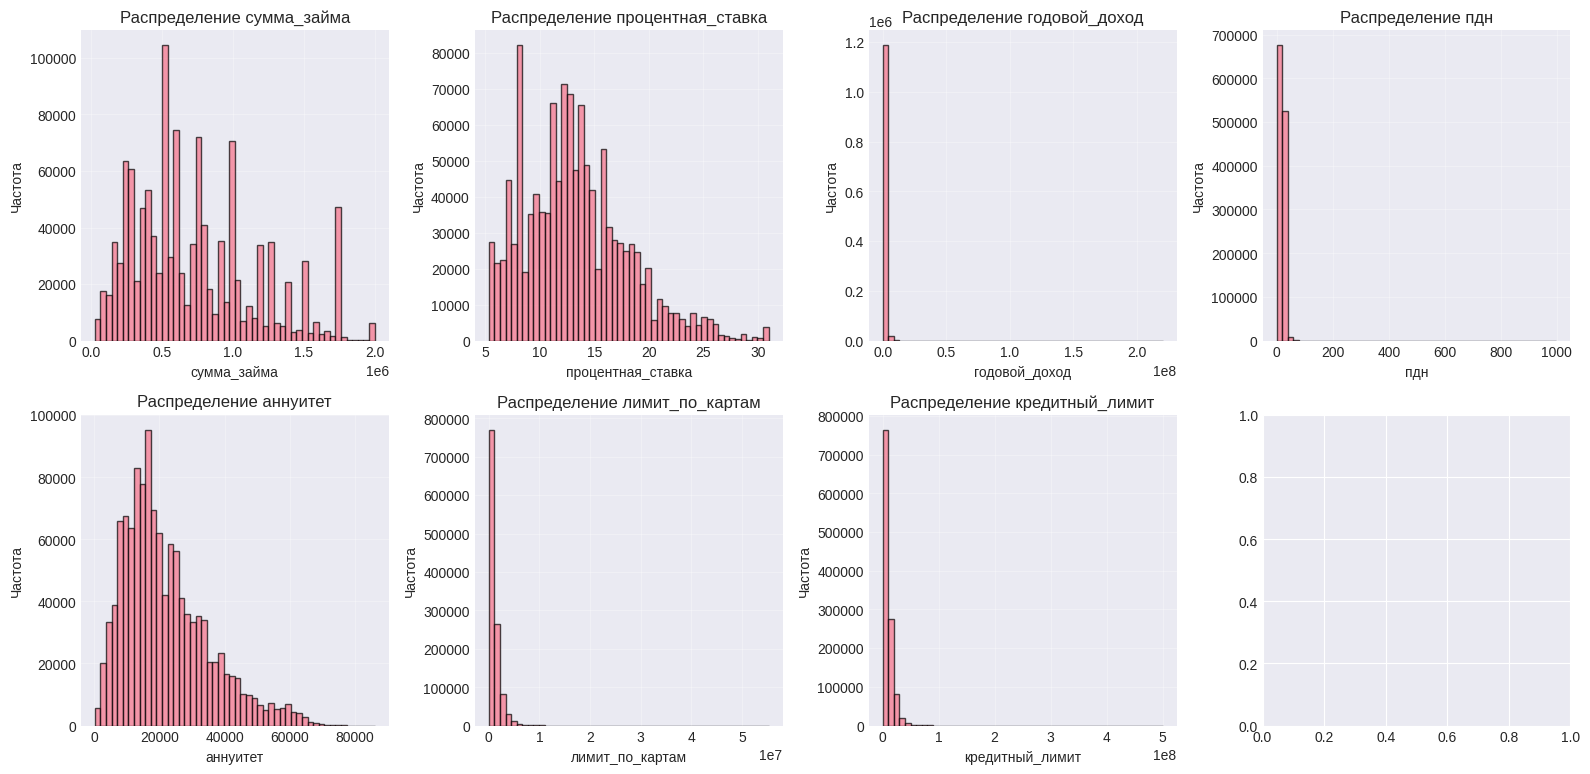

In [11]:
key_features = [
    'сумма_займа', 'процентная_ставка', 'годовой_доход', 'пдн',
    'аннуитет', 'лимит_по_картам', 'кредитный_лимит', 'возраст'
]

existing_features = [f for f in key_features if f in train.columns]

if existing_features:
    fig, axes = plt.subplots(2, 4, figsize=(16, 8))
    axes = axes.ravel()
    
    for i, feature in enumerate(existing_features[:8]):
        if feature in train.columns:
            # Гистограмма
            axes[i].hist(train[feature].dropna(), bins=50, alpha=0.7, edgecolor='black')
            axes[i].set_title(f'Распределение {feature}')
            axes[i].set_xlabel(feature)
            axes[i].set_ylabel('Частота')
            axes[i].grid(alpha=0.3)
    
    plt.tight_layout()
    plt.show()

### Анализ категориальных признаков

In [12]:
print("\nАнализ категориальных признаков:")

categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
print(f"Всего категориальных признаков: {len(categorical_cols)}")



Анализ категориальных признаков:
Всего категориальных признаков: 19


### Анализ уникальных значений

In [13]:
for col in categorical_cols[:50]:
    unique_vals = train[col].nunique()
    print(f"{col}: {unique_vals} уникальных значений")

срок_займа: 2 уникальных значений
рейтинг: 7 уникальных значений
допрейтинг: 35 уникальных значений
профессия_заемщика: 273666 уникальных значений
стаж: 11 уникальных значений
владение_жильем: 6 уникальных значений
подтвержден_ли_доход: 3 уникальных значений
платежный_график: 1 уникальных значений
цель_займа: 14 уникальных значений
регион: 51 уникальных значений
пос_стоп_фактор: 3 уникальных значений
юридический_статус: 2 уникальных значений
дата_первого_займа: 738 уникальных значений
первоначальный_статус_займа: 2 уникальных значений
пени_за_дефолт: 2 уникальных значений
тип_займа: 2 уникальных значений
совокупный_статус_подтверждения_доходов_заемщиков: 3 уникальных значений
особая_ситуация: 1 уникальных значений
тип_предоставления_кредита: 2 уникальных значений


### Анализ рейтингов


Распределение по рейтингам:
рейтинг
А    211521
Б    353530
В    343586
Г    180714
Д     84394
Е     28842
Ж      8192
Name: count, dtype: int64


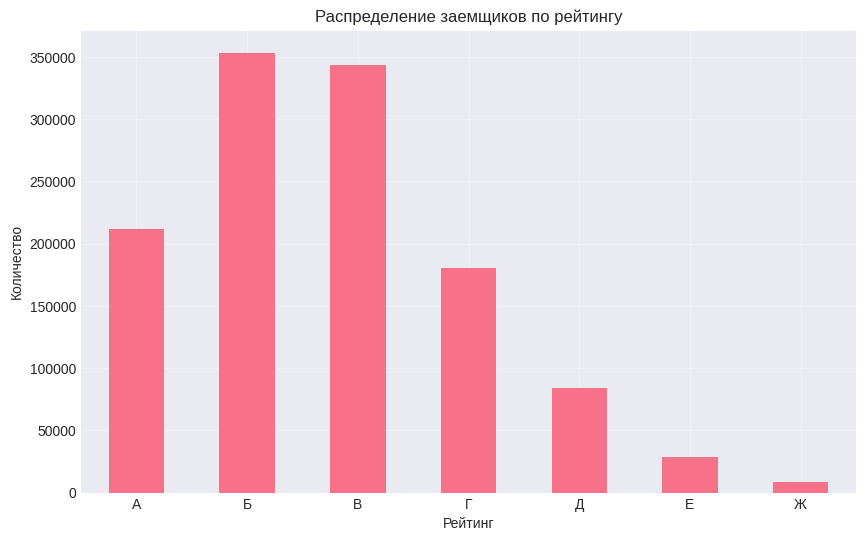

In [ ]:
if 'рейтинг' in categorical_cols:
    print("\nРаспределение по рейтингам:")
    rating_dist = train['рейтинг'].value_counts().sort_index()
    print(rating_dist)
    
    # Визуализация рейтингов
    plt.figure(figsize=(10, 6))
    rating_dist.plot(kind='bar')
    plt.title('Распределение заемщиков по рейтингу')
    plt.xlabel('Рейтинг')
    plt.ylabel('Количество')
    plt.xticks(rotation=0)
    plt.grid(alpha=0.3)
    plt.show()

### Корреляционный анализ

In [15]:
print("\nКорреляционный анализ:")

# Выбираем числовые колонки
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
if target_col in numeric_cols:
    numeric_cols.remove(target_col)



Корреляционный анализ:


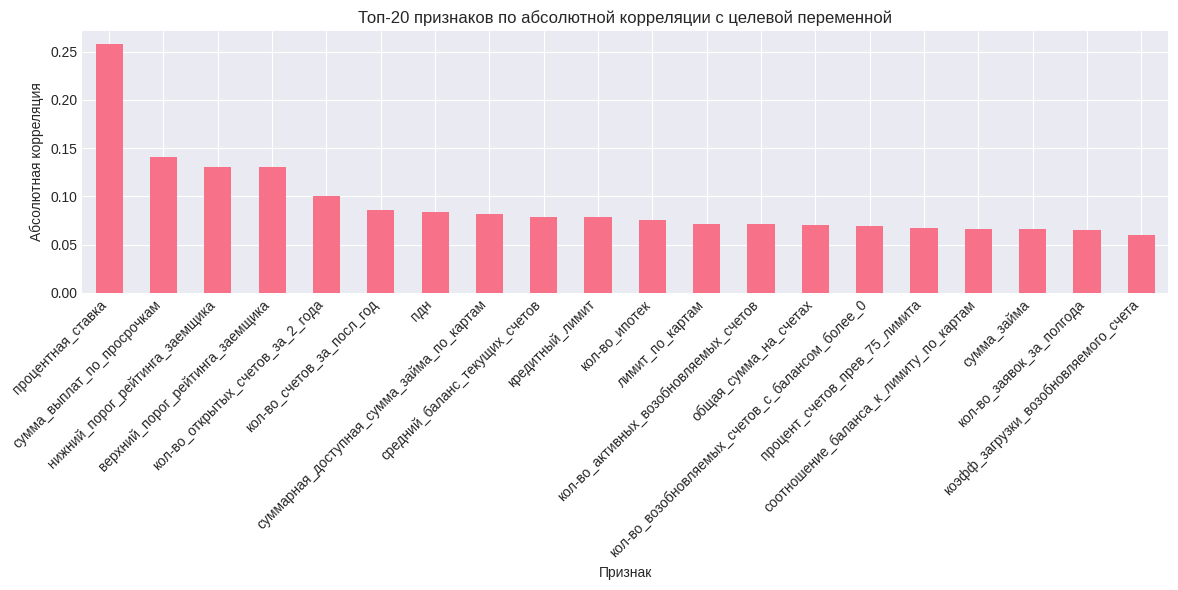


Топ-5 признаков по корреляции с итоговый_статус_займа:
процентная_ставка                  0.258
сумма_выплат_по_просрочкам         0.140
нижний_порог_рейтинга_заемщика     0.131
верхний_порог_рейтинга_заемщика    0.131
кол-во_открытых_счетов_за_2_года   0.100
Name: итоговый_статус_займа, dtype: float64


In [16]:
numeric_cols_filtered = []
for col in numeric_cols:
    if train[col].notna().sum() > len(train) * 0.5:  # Более 50% заполнено
        numeric_cols_filtered.append(col)

if len(numeric_cols_filtered) > 0:
    # Корреляции с целевой переменной
    correlations = train[numeric_cols_filtered + [target_col]].corr()[target_col].abs().sort_values(ascending=False)
    
    # Топ-20 признаков по корреляции
    top_corr = correlations[1:21]  # Исключаем саму целевую
    
    plt.figure(figsize=(12, 6))
    top_corr.plot(kind='bar')
    plt.title('Топ-20 признаков по абсолютной корреляции с целевой переменной')
    plt.xlabel('Признак')
    plt.ylabel('Абсолютная корреляция')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
    
    print(f"\nТоп-5 признаков по корреляции с {target_col}:")
    print(correlations[1:6])

## 4. Предобработка данных

### Функция для предобработки

In [17]:
def advanced_preprocessing(train_df, test_df, target_col='итоговый_статус_займа'):
    """
    Улучшенная предобработка данных
    """
    # Сохраняем ID
    train_ids = train_df['id'].copy() if 'id' in train_df.columns else None
    test_ids = test_df['id'].copy()
    
    # Объединяем для согласованной обработки
    df = pd.concat([train_df, test_df], ignore_index=True)
    original_cols = df.columns.tolist()
    
    # 1. Обработка дат
    if 'дата_первого_займа' in df.columns:
        print("Обработка дат...")
        df['дата_первого_займа'] = pd.to_datetime(df['дата_первого_займа'], format='%m-%Y', errors='coerce')
        current_date = pd.Timestamp('2026-01-01')  # Предполагаемая дата анализа
        df['стаж_кредитной_истории_мес'] = ((current_date - df['дата_первого_займа']).dt.days / 30).fillna(0)
        df['стаж_кредитной_истории_мес'] = df['стаж_кредитной_истории_мес'].clip(0, 600)  # Ограничиваем 50 лет
        df = df.drop(columns=['дата_первого_займа'])
    
    # 2. Обработка сроков займа
    if 'срок_займа' in df.columns:
        print("Обработка сроков займа...")
        df['срок_займа_мес'] = df['срок_займа'].str.extract('(\d+)').astype(float)
        df['срок_займа_мес'] = df['срок_займа_мес'] * 12  # Преобразуем годы в месяцы
        df = df.drop(columns=['срок_займа'])
    
    # 3. Кодирование рейтингов (порядковые признаки)
    rating_order = {'А': 1, 'Б': 2, 'В': 3, 'Г': 4, 'Д': 5, 'Е': 6, 'Ж': 7}
    if 'рейтинг' in df.columns:
        print("Кодирование рейтингов...")
        df['рейтинг_encoded'] = df['рейтинг'].map(rating_order).fillna(0)
        df = df.drop(columns=['рейтинг'])
    
    # 4. Создание новых признаков
    print("Создание новых признаков...")
    
    # Финансовые соотношения
    if 'аннуитет' in df.columns and 'годовой_доход' in df.columns:
        df['аннуитет_к_доходу'] = df['аннуитет'] * 12 / df['годовой_доход'].replace(0, np.nan)
    
    if 'пдн' in df.columns and 'годовой_доход' in df.columns:
        df['пдн_от_дохода'] = df['пдн'] / df['годовой_доход'].replace(0, np.nan) * 100
    
    if 'сумма_займа' in df.columns and 'годовой_доход' in df.columns:
        df['заем_к_доходу'] = df['сумма_займа'] / df['годовой_доход'].replace(0, np.nan)
    
    # Кредитные метрики
    if all(col in df.columns for col in ['кредитный_баланс_без_ипотеки', 'кредитный_лимит']):
        df['коэфф_использования_кредита'] = df['кредитный_баланс_без_ипотеки'] / df['кредитный_лимит'].replace(0, np.nan)
    
    if all(col in df.columns for col in ['лимит_по_картам', 'кредитный_лимит']):
        df['общий_лимит'] = df['лимит_по_картам'].fillna(0) + df['кредитный_лимит'].fillna(0)
    
    if all(col in df.columns for col in ['оборотный_баланс', 'общий_лимит']):
        df['коэфф_использования_общего_лимита'] = df['оборотный_баланс'] / df['общий_лимит'].replace(0, np.nan)
    
    # Временные признаки
    if 'кол-во_месяцев_с_последней_просрочки' in df.columns:
        df['давность_просрочки_кат'] = pd.cut(
            df['кол-во_месяцев_с_последней_просрочки'].fillna(999),
            bins=[0, 3, 6, 12, 24, 999],
            labels=['0-3м', '3-6м', '6-12м', '1-2г', '>2л/нет'],
            right=False
        )
    
    # 5. Обработка пропусков
    print("Обработка пропусков...")
    
    # Разделяем числовые и категориальные признаки
    numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
    
    # Для числовых - медиана
    for col in numeric_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].median())
    
    # Для категориальных - мода
    for col in categorical_cols:
        if col in df.columns:
            df[col] = df[col].fillna(df[col].mode()[0] if not df[col].mode().empty else 'Unknown')
    
    # 6. Обработка выбросов
    print("Обработка выбросов...")
    for col in numeric_cols:
        if col in df.columns:
            Q1 = df[col].quantile(0.01)  # Используем 1% и 99% перцентили
            Q3 = df[col].quantile(0.99)
            IQR = Q3 - Q1
            lower_bound = Q1 - 3 * IQR
            upper_bound = Q3 + 3 * IQR
            
            # Winsorizing
            df[col] = np.where(df[col] > upper_bound, upper_bound,
                             np.where(df[col] < lower_bound, lower_bound, df[col]))
    
    # 7. Обработка категориальных переменных
    print("Обработка категориальных переменных...")
    
    # Бинарные признаки
    binary_mapping = {'Да': 1, 'Нет': 0, 'Под вопросом': 0.5}
    for col in categorical_cols:
        if col in df.columns:
            unique_vals = df[col].unique()
            if set(unique_vals).issubset(set(binary_mapping.keys())):
                df[col] = df[col].map(binary_mapping)
                categorical_cols.remove(col)
    
    # Frequency encoding для категориальных с большим количеством значений
    for col in categorical_cols:
        if col in df.columns:
            if df[col].nunique() > 20:  # Много уникальных значений
                freq = df[col].value_counts(normalize=True)
                df[f'{col}_freq_encoded'] = df[col].map(freq)
                df = df.drop(columns=[col])
            else:
                # One-hot encoding для остальных
                dummies = pd.get_dummies(df[col], prefix=col, dummy_na=True)
                df = pd.concat([df, dummies], axis=1)
                df = df.drop(columns=[col])
    
    # 8. Масштабирование
    print("Масштабирование признаков...")
    scaler = RobustScaler()
    numeric_cols_updated = df.select_dtypes(include=[np.number]).columns.tolist()
    if target_col in numeric_cols_updated:
        numeric_cols_updated.remove(target_col)
    
    df[numeric_cols_updated] = scaler.fit_transform(df[numeric_cols_updated])
    
    # 9. Удаление константных признаков
    print("Удаление константных признаков...")
    constant_cols = [col for col in df.columns if df[col].nunique() == 1]
    if constant_cols:
        df = df.drop(columns=constant_cols)
        print(f"Удалено {len(constant_cols)} константных признаков")
    
    # 10. Разделяем обратно
    print("Разделение на train и test...")
    if target_col in df.columns:
        train_processed = df[df[target_col].notna()].copy()
        test_processed = df[df[target_col].isna()].copy()
        y = train_processed[target_col]
        X_train = train_processed.drop(columns=[target_col, 'id'] if 'id' in train_processed.columns else [target_col])
        X_test = test_processed.drop(columns=[target_col, 'id'] if 'id' in test_processed.columns else [target_col])
    else:
        X_train = df[df['id'].isin(train_ids)].drop(columns=['id'])
        X_test = df[df['id'].isin(test_ids)].drop(columns=['id'])
        y = None
    
    print(f"Обработка завершена! Train shape: {X_train.shape}, Test shape: {X_test.shape}")
    
    return X_train, X_test, y, test_ids

In [18]:
print("Запуск расширенной предобработки...")
X_train, X_test, y_train, test_ids = advanced_preprocessing(train, test, target_col)

Запуск расширенной предобработки...
Обработка дат...
Обработка сроков займа...
Кодирование рейтингов...
Создание новых признаков...
Обработка пропусков...
Обработка выбросов...
Обработка категориальных переменных...
Масштабирование признаков...
Удаление константных признаков...
Удалено 24 константных признаков
Разделение на train и test...
Обработка завершена! Train shape: (1345310, 138), Test shape: (0, 138)


In [19]:
X_train

,сумма_займа,процентная_ставка,аннуитет,годовой_доход,рейтинг_OCR,коэфф_акционных_зачислений_в_остатке,кол_во_субсидий_за_год,индекс_проживания,пдн,пос_стоп_фактор,кол-во_просрочек_за_два_года,коэфф_исходного_платежа,нижний_порог_рейтинга_заемщика,верхний_порог_рейтинга_заемщика,кол-во_заявок_за_полгода,кол-во_месяцев_с_последней_просрочки,кол-во_месяцев_с_последнего_займа,кол-во_открытых_счетов,кол-во_записей_в_общедоступных_документах,оборотный_баланс,коэфф_загрузки_возобновляемого_счета,кол-во_счетов,сумма_выплат_по_просрочкам,дата_следующей_выплаты,грейд_на_детерминаторе,кол-во_взысканий_за_последний_год,кол-во_месяцев_с_последнего_нарушения,общая_сумма_взысканий,возвраты_с_учетом_мпл,общая_сумма_на_счетах,кол-во_открытых_счетов_за_полгода,кол-во_текущих_аннуитетных_счетов,кол-во_аннуитетных_счетов_за_год,кол-во_аннуитетных_счетов_за_2_года,кол-во_месяцев_с_посл_аннуитетного_счета,текущий_баланс_по_аннуитетным_счетам,соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам,кол-во_возоб_счетов_за_год,кол-во_возоб_счетов_за_2_года,макс_баланс_по_возоб_счетам,соотношение_баланса_к_лимиту_общее,общий_лимит_по_возоб_счету,кол-во_финансовых_запросов,кол-во_финансовых_операций,кол-во_заявок_на_кредит_за_год,кол-во_открытых_счетов_за_2_года,средний_баланс_текущих_счетов,суммарная_доступная_сумма_займа_по_картам,соотношение_баланса_к_лимиту_по_картам,кол-во_месяцев_с_первого_аннуитетного_счета,кол-во_месяцев_с_первого_возобновляемого_счета,кол-во_месяцев_с_последнего_возобновляемого_счета,кол-во_месяцев_с_последнего_счета,кол-во_ипотек,кол-во_месяцев_с_последней_карты,кол-во_мес_с_последней_задолженности_по_карте,кол-во_мес_с_последней_заявки,кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,кол-во_счетов_с_просрочкой_4_мес,кол-во_активных_карт,кол-во_активных_возобновляемых_счетов,кол-во_карт_без_нарушений,кол-во_карт,кол-во_аннуитетных_счетов,кол-во_открытых_возобновляемых_счетов,кол-во_возобновляемых_счетов,кол-во_возобновляемых_счетов_с_балансом_более_0,кол-во_счетов_без_нарушений,кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года,кол-во_счетов_за_посл_год,процент_счетов_без_просрочек,процент_счетов_прев_75_лимита,кол-во_публ_банкротств,кол-во_залогов,кредитный_лимит,кредитный_баланс_без_ипотеки,лимит_по_картам,лимит_по_аннуитетным_счетам,стаж_кредитной_истории_мес,срок_займа_мес,рейтинг_encoded,аннуитет_к_доходу,пдн_от_дохода,заем_к_доходу,коэфф_использования_кредита,общий_лимит,коэфф_использования_общего_лимита,давность_просрочки_кат,допрейтинг_freq_encoded,профессия_заемщика_freq_encoded,стаж_1 год,стаж_10+ лет,стаж_2 года,стаж_3 года,стаж_4 года,стаж_5 лет,стаж_6 лет,стаж_7 лет,стаж_8 лет,стаж_9 лет,стаж_< 1 года,владение_жильем_АРЕНДА,владение_жильем_ДРУГОЕ,владение_жильем_ИПОТЕКА,владение_жильем_ЛЮБОЕ,владение_жильем_НЕТ,владение_жильем_СОБСТВЕННОСТЬ,подтвержден_ли_доход_Не подтвержден,подтвержден_ли_доход_Подтвержден,подтвержден_ли_доход_Подтвержден источник,цель_займа_автомобиль,цель_займа_возобновляемая_энергия,цель_займа_дом,цель_займа_другое,цель_займа_консолидация_долга,цель_займа_кредитная_карта,цель_займа_крупная_покупка,цель_займа_лечение,цель_займа_мелкий_бизнес,цель_займа_образование,цель_займа_отпуск,цель_займа_переезд,цель_займа_свадьба,цель_займа_улучшение_жилищных_условий,регион_freq_encoded,юридический_статус_Да,юридический_статус_Нет,первоначальный_статус_займа_а,первоначальный_статус_займа_б,пени_за_дефолт_False,пени_за_дефолт_True,тип_займа_Индивидуальный,тип_займа_Совместный,совокупный_статус_подтверждения_доходов_заемщиков_Не подтвержден,совокупный_статус_подтверждения_доходов_заемщиков_Подтвержден,совокупный_статус_подтверждения_доходов_заемщиков_Подтвержден источник,тип_предоставления_кредита_Наличные,тип_предоставления_кредита_Перевод
0,1.058,-0.120,1.339,0.000,2.000,0.797,0.000,0.170,-0.126,0.000,1.000,0.535,0.625,0.625,4.000,-25.000,0.000,1.833,0.000,0.748,-0.887,0.938,0.000,NaN,1.000,0.000,0.000,0.000,-0.949,0.722,0.000,-1.000,-1.000,0.000,7.000,-302850.000,-2.000,1.000,1.000,227

In [20]:
X_test

,сумма_займа,процентная_ставка,аннуитет,годовой_доход,рейтинг_OCR,коэфф_акционных_зачислений_в_остатке,кол_во_субсидий_за_год,индекс_проживания,пдн,пос_стоп_фактор,кол-во_просрочек_за_два_года,коэфф_исходного_платежа,нижний_порог_рейтинга_заемщика,верхний_порог_рейтинга_заемщика,кол-во_заявок_за_полгода,кол-во_месяцев_с_последней_просрочки,кол-во_месяцев_с_последнего_займа,кол-во_открытых_счетов,кол-во_записей_в_общедоступных_документах,оборотный_баланс,коэфф_загрузки_возобновляемого_счета,кол-во_счетов,сумма_выплат_по_просрочкам,дата_следующей_выплаты,грейд_на_детерминаторе,кол-во_взысканий_за_последний_год,кол-во_месяцев_с_последнего_нарушения,общая_сумма_взысканий,возвраты_с_учетом_мпл,общая_сумма_на_счетах,кол-во_открытых_счетов_за_полгода,кол-во_текущих_аннуитетных_счетов,кол-во_аннуитетных_счетов_за_год,кол-во_аннуитетных_счетов_за_2_года,кол-во_месяцев_с_посл_аннуитетного_счета,текущий_баланс_по_аннуитетным_счетам,соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам,кол-во_возоб_счетов_за_год,кол-во_возоб_счетов_за_2_года,макс_баланс_по_возоб_счетам,соотношение_баланса_к_лимиту_общее,общий_лимит_по_возоб_счету,кол-во_финансовых_запросов,кол-во_финансовых_операций,кол-во_заявок_на_кредит_за_год,кол-во_открытых_счетов_за_2_года,средний_баланс_текущих_счетов,суммарная_доступная_сумма_займа_по_картам,соотношение_баланса_к_лимиту_по_картам,кол-во_месяцев_с_первого_аннуитетного_счета,кол-во_месяцев_с_первого_возобновляемого_счета,кол-во_месяцев_с_последнего_возобновляемого_счета,кол-во_месяцев_с_последнего_счета,кол-во_ипотек,кол-во_месяцев_с_последней_карты,кол-во_мес_с_последней_задолженности_по_карте,кол-во_мес_с_последней_заявки,кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,кол-во_счетов_с_просрочкой_4_мес,кол-во_активных_карт,кол-во_активных_возобновляемых_счетов,кол-во_карт_без_нарушений,кол-во_карт,кол-во_аннуитетных_счетов,кол-во_открытых_возобновляемых_счетов,кол-во_возобновляемых_счетов,кол-во_возобновляемых_счетов_с_балансом_более_0,кол-во_счетов_без_нарушений,кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года,кол-во_счетов_за_посл_год,процент_счетов_без_просрочек,процент_счетов_прев_75_лимита,кол-во_публ_банкротств,кол-во_залогов,кредитный_лимит,кредитный_баланс_без_ипотеки,лимит_по_картам,лимит_по_аннуитетным_счетам,стаж_кредитной_истории_мес,срок_займа_мес,рейтинг_encoded,аннуитет_к_доходу,пдн_от_дохода,заем_к_доходу,коэфф_использования_кредита,общий_лимит,коэфф_использования_общего_лимита,давность_просрочки_кат,допрейтинг_freq_encoded,профессия_заемщика_freq_encoded,стаж_1 год,стаж_10+ лет,стаж_2 года,стаж_3 года,стаж_4 года,стаж_5 лет,стаж_6 лет,стаж_7 лет,стаж_8 лет,стаж_9 лет,стаж_< 1 года,владение_жильем_АРЕНДА,владение_жильем_ДРУГОЕ,владение_жильем_ИПОТЕКА,владение_жильем_ЛЮБОЕ,владение_жильем_НЕТ,владение_жильем_СОБСТВЕННОСТЬ,подтвержден_ли_доход_Не подтвержден,подтвержден_ли_доход_Подтвержден,подтвержден_ли_доход_Подтвержден источник,цель_займа_автомобиль,цель_займа_возобновляемая_энергия,цель_займа_дом,цель_займа_другое,цель_займа_консолидация_долга,цель_займа_кредитная_карта,цель_займа_крупная_покупка,цель_займа_лечение,цель_займа_мелкий_бизнес,цель_займа_образование,цель_займа_отпуск,цель_займа_переезд,цель_займа_свадьба,цель_займа_улучшение_жилищных_условий,регион_freq_encoded,юридический_статус_Да,юридический_статус_Нет,первоначальный_статус_займа_а,первоначальный_статус_займа_б,пени_за_дефолт_False,пени_за_дефолт_True,тип_займа_Индивидуальный,тип_займа_Совместный,совокупный_статус_подтверждения_доходов_заемщиков_Не подтвержден,совокупный_статус_подтверждения_доходов_заемщиков_Подтвержден,совокупный_статус_подтверждения_доходов_заемщиков_Подтвержден источник,тип_предоставления_кредита_Наличные,тип_предоставления_кредита_Перевод


In [21]:
y_train

0         0.000
1         0.000
2         0.000
3         0.000
4         0.000
           ... 
1345305   0.000
1345306   0.000
1345307   0.000
1345308   0.000
1345309   0.000
Name: итоговый_статус_займа, Length: 1345310, dtype: float64

In [22]:
test_ids

0         85540387
1         28112500
2         65731570
3         65874747
4         57893355
            ...   
134526    72082596
134527      484702
134528    73273241
134529    50466330
134530    46350249
Name: id, Length: 134531, dtype: int64

In [23]:
print(f"\nРезультаты предобработки:")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape if y_train is not None else 'N/A'}")
print(f"\nПример обработанных данных:")
display(X_train.head())


Результаты предобработки:
X_train shape: (1345310, 138)
X_test shape: (0, 138)
y_train shape: (1345310,)

Пример обработанных данных:


,сумма_займа,процентная_ставка,аннуитет,годовой_доход,рейтинг_OCR,коэфф_акционных_зачислений_в_остатке,кол_во_субсидий_за_год,индекс_проживания,пдн,пос_стоп_фактор,кол-во_просрочек_за_два_года,коэфф_исходного_платежа,нижний_порог_рейтинга_заемщика,верхний_порог_рейтинга_заемщика,кол-во_заявок_за_полгода,кол-во_месяцев_с_последней_просрочки,кол-во_месяцев_с_последнего_займа,кол-во_открытых_счетов,кол-во_записей_в_общедоступных_документах,оборотный_баланс,коэфф_загрузки_возобновляемого_счета,кол-во_счетов,сумма_выплат_по_просрочкам,дата_следующей_выплаты,грейд_на_детерминаторе,кол-во_взысканий_за_последний_год,кол-во_месяцев_с_последнего_нарушения,общая_сумма_взысканий,возвраты_с_учетом_мпл,общая_сумма_на_счетах,кол-во_открытых_счетов_за_полгода,кол-во_текущих_аннуитетных_счетов,кол-во_аннуитетных_счетов_за_год,кол-во_аннуитетных_счетов_за_2_года,кол-во_месяцев_с_посл_аннуитетного_счета,текущий_баланс_по_аннуитетным_счетам,соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам,кол-во_возоб_счетов_за_год,кол-во_возоб_счетов_за_2_года,макс_баланс_по_возоб_счетам,соотношение_баланса_к_лимиту_общее,общий_лимит_по_возоб_счету,кол-во_финансовых_запросов,кол-во_финансовых_операций,кол-во_заявок_на_кредит_за_год,кол-во_открытых_счетов_за_2_года,средний_баланс_текущих_счетов,суммарная_доступная_сумма_займа_по_картам,соотношение_баланса_к_лимиту_по_картам,кол-во_месяцев_с_первого_аннуитетного_счета,кол-во_месяцев_с_первого_возобновляемого_счета,кол-во_месяцев_с_последнего_возобновляемого_счета,кол-во_месяцев_с_последнего_счета,кол-во_ипотек,кол-во_месяцев_с_последней_карты,кол-во_мес_с_последней_задолженности_по_карте,кол-во_мес_с_последней_заявки,кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,кол-во_счетов_с_просрочкой_4_мес,кол-во_активных_карт,кол-во_активных_возобновляемых_счетов,кол-во_карт_без_нарушений,кол-во_карт,кол-во_аннуитетных_счетов,кол-во_открытых_возобновляемых_счетов,кол-во_возобновляемых_счетов,кол-во_возобновляемых_счетов_с_балансом_более_0,кол-во_счетов_без_нарушений,кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года,кол-во_счетов_за_посл_год,процент_счетов_без_просрочек,процент_счетов_прев_75_лимита,кол-во_публ_банкротств,кол-во_залогов,кредитный_лимит,кредитный_баланс_без_ипотеки,лимит_по_картам,лимит_по_аннуитетным_счетам,стаж_кредитной_истории_мес,срок_займа_мес,рейтинг_encoded,аннуитет_к_доходу,пдн_от_дохода,заем_к_доходу,коэфф_использования_кредита,общий_лимит,коэфф_использования_общего_лимита,давность_просрочки_кат,допрейтинг_freq_encoded,профессия_заемщика_freq_encoded,стаж_1 год,стаж_10+ лет,стаж_2 года,стаж_3 года,стаж_4 года,стаж_5 лет,стаж_6 лет,стаж_7 лет,стаж_8 лет,стаж_9 лет,стаж_< 1 года,владение_жильем_АРЕНДА,владение_жильем_ДРУГОЕ,владение_жильем_ИПОТЕКА,владение_жильем_ЛЮБОЕ,владение_жильем_НЕТ,владение_жильем_СОБСТВЕННОСТЬ,подтвержден_ли_доход_Не подтвержден,подтвержден_ли_доход_Подтвержден,подтвержден_ли_доход_Подтвержден источник,цель_займа_автомобиль,цель_займа_возобновляемая_энергия,цель_займа_дом,цель_займа_другое,цель_займа_консолидация_долга,цель_займа_кредитная_карта,цель_займа_крупная_покупка,цель_займа_лечение,цель_займа_мелкий_бизнес,цель_займа_образование,цель_займа_отпуск,цель_займа_переезд,цель_займа_свадьба,цель_займа_улучшение_жилищных_условий,регион_freq_encoded,юридический_статус_Да,юридический_статус_Нет,первоначальный_статус_займа_а,первоначальный_статус_займа_б,пени_за_дефолт_False,пени_за_дефолт_True,тип_займа_Индивидуальный,тип_займа_Совместный,совокупный_статус_подтверждения_доходов_заемщиков_Не подтвержден,совокупный_статус_подтверждения_доходов_заемщиков_Подтвержден,совокупный_статус_подтверждения_доходов_заемщиков_Подтвержден источник,тип_предоставления_кредита_Наличные,тип_предоставления_кредита_Перевод
0,1.058,-0.120,1.339,0.000,2.000,0.797,0.000,0.170,-0.126,0.000,1.000,0.535,0.625,0.625,4.000,-25.000,0.000,1.833,0.000,0.748,-0.887,0.938,0.000,NaN,1.000,0.000,0.000,0.000,-0.949,0.722,0.000,-1.000,-1.000,0.000,7.000,-302850.000,-2.000,1.000,1.000,227

## 5. Разделение данных и базовая модель

In [3]:
# Разделение на train/validation
print("Разделение на train и validation...")
X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(
    X_train, y_train, test_size=0.2, random_state=RANDOM_STATE, stratify=y_train
)

print(f"Train split: {X_train_split.shape}")
print(f"Validation split: {X_val_split.shape}")

Разделение на train и validation...


NameError: name 'train_test_split' is not defined

In [25]:
X_train_split

,сумма_займа,процентная_ставка,аннуитет,годовой_доход,рейтинг_OCR,коэфф_акционных_зачислений_в_остатке,кол_во_субсидий_за_год,индекс_проживания,пдн,пос_стоп_фактор,кол-во_просрочек_за_два_года,коэфф_исходного_платежа,нижний_порог_рейтинга_заемщика,верхний_порог_рейтинга_заемщика,кол-во_заявок_за_полгода,кол-во_месяцев_с_последней_просрочки,кол-во_месяцев_с_последнего_займа,кол-во_открытых_счетов,кол-во_записей_в_общедоступных_документах,оборотный_баланс,коэфф_загрузки_возобновляемого_счета,кол-во_счетов,сумма_выплат_по_просрочкам,дата_следующей_выплаты,грейд_на_детерминаторе,кол-во_взысканий_за_последний_год,кол-во_месяцев_с_последнего_нарушения,общая_сумма_взысканий,возвраты_с_учетом_мпл,общая_сумма_на_счетах,кол-во_открытых_счетов_за_полгода,кол-во_текущих_аннуитетных_счетов,кол-во_аннуитетных_счетов_за_год,кол-во_аннуитетных_счетов_за_2_года,кол-во_месяцев_с_посл_аннуитетного_счета,текущий_баланс_по_аннуитетным_счетам,соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам,кол-во_возоб_счетов_за_год,кол-во_возоб_счетов_за_2_года,макс_баланс_по_возоб_счетам,соотношение_баланса_к_лимиту_общее,общий_лимит_по_возоб_счету,кол-во_финансовых_запросов,кол-во_финансовых_операций,кол-во_заявок_на_кредит_за_год,кол-во_открытых_счетов_за_2_года,средний_баланс_текущих_счетов,суммарная_доступная_сумма_займа_по_картам,соотношение_баланса_к_лимиту_по_картам,кол-во_месяцев_с_первого_аннуитетного_счета,кол-во_месяцев_с_первого_возобновляемого_счета,кол-во_месяцев_с_последнего_возобновляемого_счета,кол-во_месяцев_с_последнего_счета,кол-во_ипотек,кол-во_месяцев_с_последней_карты,кол-во_мес_с_последней_задолженности_по_карте,кол-во_мес_с_последней_заявки,кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,кол-во_счетов_с_просрочкой_4_мес,кол-во_активных_карт,кол-во_активных_возобновляемых_счетов,кол-во_карт_без_нарушений,кол-во_карт,кол-во_аннуитетных_счетов,кол-во_открытых_возобновляемых_счетов,кол-во_возобновляемых_счетов,кол-во_возобновляемых_счетов_с_балансом_более_0,кол-во_счетов_без_нарушений,кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года,кол-во_счетов_за_посл_год,процент_счетов_без_просрочек,процент_счетов_прев_75_лимита,кол-во_публ_банкротств,кол-во_залогов,кредитный_лимит,кредитный_баланс_без_ипотеки,лимит_по_картам,лимит_по_аннуитетным_счетам,стаж_кредитной_истории_мес,срок_займа_мес,рейтинг_encoded,аннуитет_к_доходу,пдн_от_дохода,заем_к_доходу,коэфф_использования_кредита,общий_лимит,коэфф_использования_общего_лимита,давность_просрочки_кат,допрейтинг_freq_encoded,профессия_заемщика_freq_encoded,стаж_1 год,стаж_10+ лет,стаж_2 года,стаж_3 года,стаж_4 года,стаж_5 лет,стаж_6 лет,стаж_7 лет,стаж_8 лет,стаж_9 лет,стаж_< 1 года,владение_жильем_АРЕНДА,владение_жильем_ДРУГОЕ,владение_жильем_ИПОТЕКА,владение_жильем_ЛЮБОЕ,владение_жильем_НЕТ,владение_жильем_СОБСТВЕННОСТЬ,подтвержден_ли_доход_Не подтвержден,подтвержден_ли_доход_Подтвержден,подтвержден_ли_доход_Подтвержден источник,цель_займа_автомобиль,цель_займа_возобновляемая_энергия,цель_займа_дом,цель_займа_другое,цель_займа_консолидация_долга,цель_займа_кредитная_карта,цель_займа_крупная_покупка,цель_займа_лечение,цель_займа_мелкий_бизнес,цель_займа_образование,цель_займа_отпуск,цель_займа_переезд,цель_займа_свадьба,цель_займа_улучшение_жилищных_условий,регион_freq_encoded,юридический_статус_Да,юридический_статус_Нет,первоначальный_статус_займа_а,первоначальный_статус_займа_б,пени_за_дефолт_False,пени_за_дефолт_True,тип_займа_Индивидуальный,тип_займа_Совместный,совокупный_статус_подтверждения_доходов_заемщиков_Не подтвержден,совокупный_статус_подтверждения_доходов_заемщиков_Подтвержден,совокупный_статус_подтверждения_доходов_заемщиков_Подтвержден источник,тип_предоставления_кредита_Наличные,тип_предоставления_кредита_Перевод
1224261,-0.500,-0.008,-0.524,-0.656,-1.000,0.772,0.000,0.825,-0.093,0.000,0.000,0.577,1.375,1.375,3.000,32.000,0.000,0.167,0.000,-0.560,-1.056,-0.250,0.000,NaN,0.500,0.000,0.000,0.000,0.565,-0.395,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0

In [26]:
X_val_split

,сумма_займа,процентная_ставка,аннуитет,годовой_доход,рейтинг_OCR,коэфф_акционных_зачислений_в_остатке,кол_во_субсидий_за_год,индекс_проживания,пдн,пос_стоп_фактор,кол-во_просрочек_за_два_года,коэфф_исходного_платежа,нижний_порог_рейтинга_заемщика,верхний_порог_рейтинга_заемщика,кол-во_заявок_за_полгода,кол-во_месяцев_с_последней_просрочки,кол-во_месяцев_с_последнего_займа,кол-во_открытых_счетов,кол-во_записей_в_общедоступных_документах,оборотный_баланс,коэфф_загрузки_возобновляемого_счета,кол-во_счетов,сумма_выплат_по_просрочкам,дата_следующей_выплаты,грейд_на_детерминаторе,кол-во_взысканий_за_последний_год,кол-во_месяцев_с_последнего_нарушения,общая_сумма_взысканий,возвраты_с_учетом_мпл,общая_сумма_на_счетах,кол-во_открытых_счетов_за_полгода,кол-во_текущих_аннуитетных_счетов,кол-во_аннуитетных_счетов_за_год,кол-во_аннуитетных_счетов_за_2_года,кол-во_месяцев_с_посл_аннуитетного_счета,текущий_баланс_по_аннуитетным_счетам,соотношение_сумм_текущего_баланса_к_лимиту_по_аннуитетным_счетам,кол-во_возоб_счетов_за_год,кол-во_возоб_счетов_за_2_года,макс_баланс_по_возоб_счетам,соотношение_баланса_к_лимиту_общее,общий_лимит_по_возоб_счету,кол-во_финансовых_запросов,кол-во_финансовых_операций,кол-во_заявок_на_кредит_за_год,кол-во_открытых_счетов_за_2_года,средний_баланс_текущих_счетов,суммарная_доступная_сумма_займа_по_картам,соотношение_баланса_к_лимиту_по_картам,кол-во_месяцев_с_первого_аннуитетного_счета,кол-во_месяцев_с_первого_возобновляемого_счета,кол-во_месяцев_с_последнего_возобновляемого_счета,кол-во_месяцев_с_последнего_счета,кол-во_ипотек,кол-во_месяцев_с_последней_карты,кол-во_мес_с_последней_задолженности_по_карте,кол-во_мес_с_последней_заявки,кол-во_мес_с_последней_задолженности_по_возобновляемому_счету,кол-во_счетов_с_просрочкой_4_мес,кол-во_активных_карт,кол-во_активных_возобновляемых_счетов,кол-во_карт_без_нарушений,кол-во_карт,кол-во_аннуитетных_счетов,кол-во_открытых_возобновляемых_счетов,кол-во_возобновляемых_счетов,кол-во_возобновляемых_счетов_с_балансом_более_0,кол-во_счетов_без_нарушений,кол-во_счетов_с_акт_просрочкой_3_мес_за_2_года,кол-во_счетов_за_посл_год,процент_счетов_без_просрочек,процент_счетов_прев_75_лимита,кол-во_публ_банкротств,кол-во_залогов,кредитный_лимит,кредитный_баланс_без_ипотеки,лимит_по_картам,лимит_по_аннуитетным_счетам,стаж_кредитной_истории_мес,срок_займа_мес,рейтинг_encoded,аннуитет_к_доходу,пдн_от_дохода,заем_к_доходу,коэфф_использования_кредита,общий_лимит,коэфф_использования_общего_лимита,давность_просрочки_кат,допрейтинг_freq_encoded,профессия_заемщика_freq_encoded,стаж_1 год,стаж_10+ лет,стаж_2 года,стаж_3 года,стаж_4 года,стаж_5 лет,стаж_6 лет,стаж_7 лет,стаж_8 лет,стаж_9 лет,стаж_< 1 года,владение_жильем_АРЕНДА,владение_жильем_ДРУГОЕ,владение_жильем_ИПОТЕКА,владение_жильем_ЛЮБОЕ,владение_жильем_НЕТ,владение_жильем_СОБСТВЕННОСТЬ,подтвержден_ли_доход_Не подтвержден,подтвержден_ли_доход_Подтвержден,подтвержден_ли_доход_Подтвержден источник,цель_займа_автомобиль,цель_займа_возобновляемая_энергия,цель_займа_дом,цель_займа_другое,цель_займа_консолидация_долга,цель_займа_кредитная_карта,цель_займа_крупная_покупка,цель_займа_лечение,цель_займа_мелкий_бизнес,цель_займа_образование,цель_займа_отпуск,цель_займа_переезд,цель_займа_свадьба,цель_займа_улучшение_жилищных_условий,регион_freq_encoded,юридический_статус_Да,юридический_статус_Нет,первоначальный_статус_займа_а,первоначальный_статус_займа_б,пени_за_дефолт_False,пени_за_дефолт_True,тип_займа_Индивидуальный,тип_займа_Совместный,совокупный_статус_подтверждения_доходов_заемщиков_Не подтвержден,совокупный_статус_подтверждения_доходов_заемщиков_Подтвержден,совокупный_статус_подтверждения_доходов_заемщиков_Подтвержден источник,тип_предоставления_кредита_Наличные,тип_предоставления_кредита_Перевод
1322154,1.667,-0.191,2.048,0.673,-1.000,0.780,3.000,0.517,0.614,0.000,0.000,-0.956,0.375,0.375,1.000,0.000,0.000,-0.167,0.000,1.618,0.315,-0.375,0.000,NaN,-0.500,0.000,0.000,441.000,-0.529,1.099,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0

In [27]:
y_train_split

1224261   0.000
1035019   0.000
1000872   1.000
657386    0.000
147434    0.000
           ... 
419502    0.000
947309    0.000
270459    0.000
141215    0.000
970738    0.000
Name: итоговый_статус_займа, Length: 1076248, dtype: float64

In [28]:
y_val_split

1322154   0.000
350674    0.000
105851    0.000
260499    0.000
241530    0.000
           ... 
383598    0.000
554064    0.000
734972    1.000
827174    1.000
1004291   0.000
Name: итоговый_статус_займа, Length: 269062, dtype: float64

### Базовая модель (LightGBM)

In [29]:
print("\nОбучение базовой модели LightGBM...")

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'boosting_type': 'gbdt',
    'n_estimators': 500,
    'learning_rate': 0.05,
    'max_depth': 7,
    'num_leaves': 31,
    'min_child_samples': 20,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.1,
    'reg_lambda': 0.1,
    'random_state': RANDOM_STATE,
    'n_jobs': -1,
    'verbose': -1
}

lgb_model = lgb.LGBMClassifier(**lgb_params)
lgb_model


Обучение базовой модели LightGBM...


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,7
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


In [30]:
lgb_model.fit(
    X_train_split, y_train_split,
    eval_set=[(X_val_split, y_val_split)],
    eval_metric='auc',
    callbacks=[
        lgb.early_stopping(stopping_rounds=50, verbose=False),
        lgb.log_evaluation(period=100)
    ]
)


[100]	valid_0's auc: 0.86064
[200]	valid_0's auc: 0.863521
[300]	valid_0's auc: 0.864916
[400]	valid_0's auc: 0.865513
[500]	valid_0's auc: 0.865877


,boosting_type,'gbdt'
,num_leaves,31
,max_depth,7
,learning_rate,0.05
,n_estimators,500
,subsample_for_bin,200000
,objective,'binary'
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


### Предсказания

In [31]:
y_pred_proba_lgb = lgb_model.predict_proba(X_val_split)[:, 1]
y_pred_proba_lgb

array([0.03018523, 0.19309498, 0.04827245, ..., 0.99994845, 0.99994596,
       0.06878854], shape=(269062,))

In [32]:
auc_lgb = roc_auc_score(y_val_split, y_pred_proba_lgb)
print(f"\nLightGBM Baseline AUC: {auc_lgb:.4f}")


LightGBM Baseline AUC: 0.8659


### Визуализация ROC-кривой

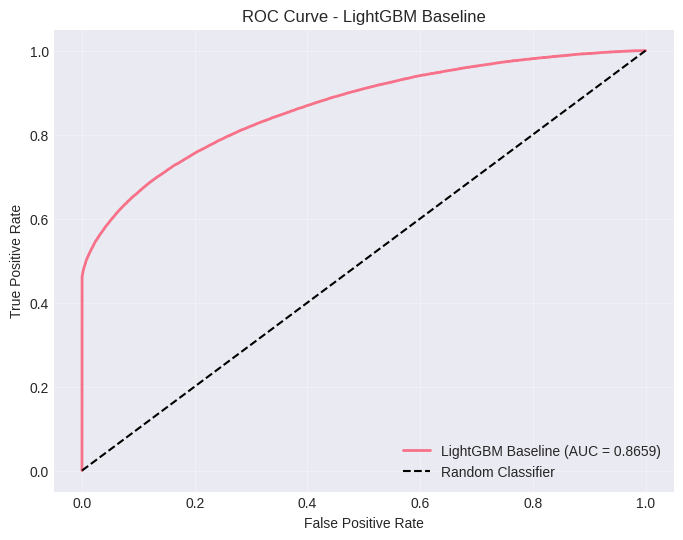

0.8658770509935279

In [33]:
def plot_roc_curve(y_true, y_pred_proba, model_name="Model"):
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    auc_score = roc_auc_score(y_true, y_pred_proba)
    
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc_score:.4f})', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve - {model_name}')
    plt.legend(loc='lower right')
    plt.grid(alpha=0.3)
    plt.show()
    
    return auc_score

plot_roc_curve(y_val_split, y_pred_proba_lgb, "LightGBM Baseline")

## 6. Сравнение разных моделей

In [1]:
print("Сравнение разных моделей...")

def train_and_evaluate_models(X_train, y_train, X_val, y_val):
    models = {
        'LightGBM': lgb.LGBMClassifier(
            objective='binary',
            metric='auc',
            n_estimators=300,
            learning_rate=0.05,
            max_depth=7,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbose=-1
        ),
        'XGBoost': xgb.XGBClassifier(
            objective='binary:logistic',
            eval_metric='auc',
            n_estimators=300,
            learning_rate=0.05,
            max_depth=6,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            verbosity=0
        ),
        'CatBoost': CatBoostClassifier(
            loss_function='Logloss',
            eval_metric='AUC',
            iterations=300,
            learning_rate=0.05,
            depth=6,
            random_state=RANDOM_STATE,
            verbose=0,
            thread_count=-1
        ),
        'RandomForest': RandomForestClassifier(
            n_estimators=200,
            max_depth=10,
            random_state=RANDOM_STATE,
            n_jobs=-1,
            class_weight='balanced'
        )
    }
    
    results = {}
    
    for name, model in models.items():
        print(f"\nОбучение {name}...")
        
        try:
            if name in ['LightGBM', 'XGBoost', 'CatBoost']:
                model.fit(
                    X_train, y_train,
                    eval_set=[(X_val, y_val)],
                    verbose=False
                )
            else:
                model.fit(X_train, y_train)
            
            # Предсказания
            if hasattr(model, 'predict_proba'):
                y_pred_proba = model.predict_proba(X_val)[:, 1]
            else:
                y_pred_proba = model.predict(X_val)
            
            # Расчет AUC
            auc_score = roc_auc_score(y_val, y_pred_proba)
            results[name] = {
                'model': model,
                'auc': auc_score,
                'predictions': y_pred_proba
            }
            
            print(f"{name} AUC: {auc_score:.4f}")
            
        except Exception as e:
            print(f"Ошибка при обучении {name}: {str(e)}")
            results[name] = {
                'model': None,
                'auc': 0,
                'predictions': None
            }
    
    # Сортировка по AUC
    sorted_results = sorted(results.items(), key=lambda x: x[1]['auc'], reverse=True)
    
    print("\n" + "="*60)
    print("РЕЙТИНГ МОДЕЛЕЙ ПО AUC:")
    print("="*60)
    for rank, (name, data) in enumerate(sorted_results, 1):
        if data['model'] is not None:
            print(f"{rank}. {name}: AUC = {data['auc']:.4f}")
    
    return results, sorted_results

Сравнение разных моделей...


### Обучение и сравнение моделей

In [2]:
model_results, sorted_models = train_and_evaluate_models(
    X_train_split, y_train_split, X_val_split, y_val_split
)

NameError: name 'X_train_split' is not defined

### Визуализация сравнения ROC-кривых


Визуализация сравнения ROC-кривых...


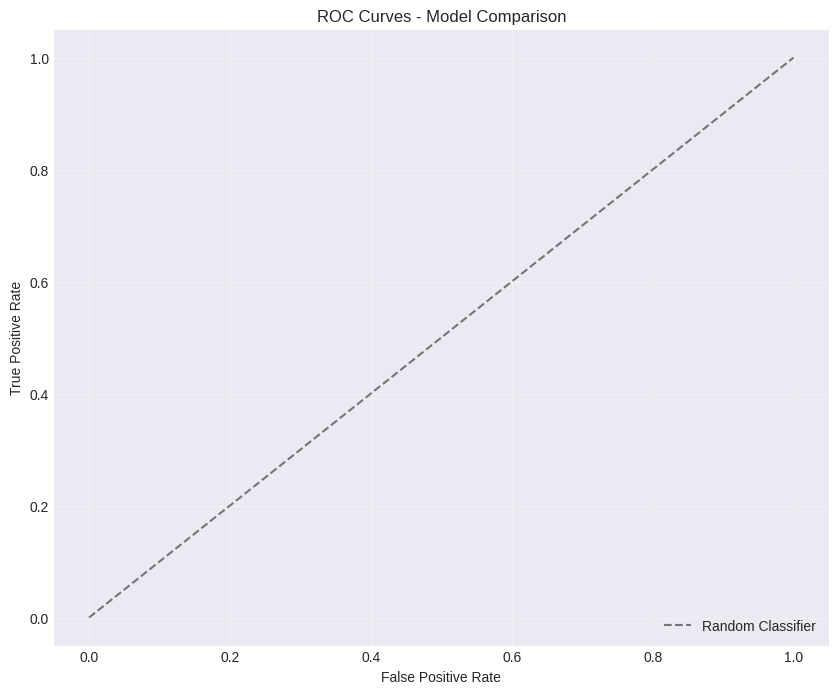

In [38]:
print("\nВизуализация сравнения ROC-кривых...")

plt.figure(figsize=(10, 8))
for name, data in model_results.items():
    if data['model'] is not None and data['predictions'] is not None:
        fpr, tpr, _ = roc_curve(y_val_split, data['predictions'])
        plt.plot(fpr, tpr, label=f'{name} (AUC = {data["auc"]:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Model Comparison')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()


## 7. Стекинг моделей

In [ ]:
# Создание стекинга моделей
print("Создание стекинга моделей...")

# Выбираем топ-3 модели
top_models_names = [name for name, _ in sorted_models[:3]]
print(f"Топ-3 модели для стекинга: {top_models_names}")

# Создаем список оценщиков для стекинга
estimators = []
for name in top_models_names:
    if name in model_results and model_results[name]['model'] is not None:
        estimators.append((name, model_results[name]['model']))

if estimators:
    # Мета-модель
    meta_model = LogisticRegression(
        C=0.1,
        max_iter=1000,
        random_state=RANDOM_STATE,
        n_jobs=-1,
        class_weight='balanced'
    )
    
    # Стекинг классификатор
    stacking_model = StackingClassifier(
        estimators=estimators,
        final_estimator=meta_model,
        cv=5,
        n_jobs=-1,
        passthrough=False  # Используем только предсказания моделей
    )
    
    # Обучение стекинга
    print("Обучение стекинга...")
    stacking_model.fit(X_train_split, y_train_split)
    
    # Оценка стекинга
    y_pred_proba_stacking = stacking_model.predict_proba(X_val_split)[:, 1]
    auc_stacking = roc_auc_score(y_val_split, y_pred_proba_stacking)
    
    print(f"Stacking Model AUC: {auc_stacking:.4f}")
    
    # Добавляем стекинг в результаты
    model_results['Stacking'] = {
        'model': stacking_model,
        'auc': auc_stacking,
        'predictions': y_pred_proba_stacking
    }
    
    # Обновляем сортировку
    sorted_models = sorted(model_results.items(), key=lambda x: x[1]['auc'], reverse=True)
    
    print("\nОбновленный рейтинг:")
    for rank, (name, data) in enumerate(sorted_models, 1):
        if data['model'] is not None:
            print(f"{rank}. {name}: AUC = {data['auc']:.4f}")
else:
    print("Не удалось создать стекинг из-за отсутствия моделей")

## 8. Кросс-валидация

In [ ]:
# Стратифицированная кросс-валидация для лучшей модели
print("\nКросс-валидация лучшей модели...")
best_model_name = sorted_models[0][0]
best_model = model_results[best_model_name]['model']
print(f"Лучшая модель: {best_model_name}")

In [ ]:
# Кросс-валидация
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
cv_scores = cross_val_score(
    best_model, X_train, y_train,
    cv=cv, scoring='roc_auc', n_jobs=-1
)
print(f"\nКросс-валидация AUC scores: {cv_scores}")
print(f"Mean AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

### Визуализация результатов

In [ ]:
plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.boxplot(cv_scores)
plt.title('Cross-validation AUC Scores')
plt.ylabel('AUC')

plt.subplot(1, 2, 2)
plt.plot(range(1, len(cv_scores)+1), cv_scores, 'o-', linewidth=2, markersize=8)
plt.axhline(y=cv_scores.mean(), color='r', linestyle='--', label=f'Mean: {cv_scores.mean():.4f}')
plt.fill_between(range(1, len(cv_scores)+1), 
                 cv_scores.mean() - cv_scores.std(), 
                 cv_scores.mean() + cv_scores.std(), 
                 alpha=0.2, color='gray')
plt.title('CV Scores by Fold')
plt.xlabel('Fold')
plt.ylabel('AUC')
plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 9. Обучение финальной модели на всех данных

In [ ]:
print("\nОбучение финальной модели на всех данных...")

# Используем лучшую модель
final_model = best_model

# Если это стекинг, переобучаем на всех данных
if best_model_name == 'Stacking':
    print("Переобучение стекинга на всех данных...")
    final_model.fit(X_train, y_train)
else:
    print(f"Используем предобученную модель {best_model_name}")

# Предсказания на валидации для оценки
if hasattr(final_model, 'predict_proba'):
    y_final_pred_proba = final_model.predict_proba(X_val_split)[:, 1]
else:
    y_final_pred_proba = final_model.predict(X_val_split)

final_auc = roc_auc_score(y_val_split, y_final_pred_proba)
print(f"Финальная модель AUC на validation: {final_auc:.4f}")

# Визуализация финальной ROC-кривой
plot_roc_curve(y_val_split, y_final_pred_proba, f"Final {best_model_name} Model")

## 10. Анализ важности признаков

In [ ]:
# Анализ важности признаков для интерпретируемости
print("\nАнализ важности признаков...")

def plot_feature_importance(model, feature_names, top_n=30, model_name="Model"):
    """
    Визуализация важности признаков
    """
    if hasattr(model, 'feature_importances_'):
        # Для tree-based моделей
        importance = model.feature_importances_
    elif hasattr(model, 'coef_'):
        # Для линейных моделей
        importance = np.abs(model.coef_[0])
    else:
        print(f"Модель {model_name} не поддерживает анализ важности признаков")
        return None
    
    # Создаем DataFrame
    feat_imp = pd.DataFrame({
        'feature': feature_names[:len(importance)],
        'importance': importance
    }).sort_values('importance', ascending=False).head(top_n)
    
    # Визуализация
    plt.figure(figsize=(12, 8))
    bars = plt.barh(range(len(feat_imp)), feat_imp['importance'])
    plt.yticks(range(len(feat_imp)), feat_imp['feature'])
    plt.xlabel('Feature Importance')
    plt.title(f'Top {top_n} Most Important Features - {model_name}')
    plt.gca().invert_yaxis()
    
    # Добавляем значения на столбцах
    for i, (bar, imp) in enumerate(zip(bars, feat_imp['importance'])):
        plt.text(imp, i, f' {imp:.4f}', va='center')
    
    plt.tight_layout()
    plt.show()
    
    return feat_imp

In [ ]:
# Анализ важности признаков для лучшей модели
if best_model_name != 'Stacking':
    feature_importance = plot_feature_importance(
        final_model, X_train.columns.tolist(), top_n=20, model_name=best_model_name
    )
    
    if feature_importance is not None:
        print("\nТоп-10 самых важных признаков:")
        display(feature_importance.head(10))

## 11. Предсказания на тестовых данных

In [ ]:
print("\nГенерация предсказаний на тестовых данных...")

# Проверяем, что финальная модель обучена
if hasattr(final_model, 'predict_proba'):
    test_predictions = final_model.predict_proba(X_test)[:, 1]
else:
    test_predictions = final_model.predict(X_test)

print(f"Сгенерировано {len(test_predictions)} предсказаний")

# Анализ распределения предсказаний
print("\nСтатистика предсказаний:")
print(f"Min probability: {test_predictions.min():.6f}")
print(f"Max probability: {test_predictions.max():.6f}")
print(f"Mean probability: {test_predictions.mean():.6f}")
print(f"Std probability: {test_predictions.std():.6f}")

# Гистограмма предсказаний
plt.figure(figsize=(10, 5))
plt.hist(test_predictions, bins=50, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted Probability')
plt.ylabel('Frequency')
plt.title('Distribution of Predicted Probabilities on Test Set')
plt.grid(alpha=0.3)
plt.show()

# Проверка на NaN
if np.isnan(test_predictions).any():
    nan_count = np.isnan(test_predictions).sum()
    print(f"\nВНИМАНИЕ: Найдено {nan_count} NaN значений в предсказаниях!")
    print("Заменяем NaN на среднее значение...")
    test_predictions = np.nan_to_num(test_predictions, nan=test_predictions[~np.isnan(test_predictions)].mean())

## 12. Формирование сабмита

In [ ]:
# Создание файла submission.csv
print("\nФормирование файла submission.csv...")

submission = pd.DataFrame({
    'ID': test_ids,
    'Proba': test_predictions
})

In [ ]:
# Проверяем формат
print("Проверка формата сабмита:")
print(f"Размер: {submission.shape}")
print(f"Колонки: {submission.columns.tolist()}")
print(f"Типы данных:\n{submission.dtypes}")

# Первые несколько строк
print("\nПервые 10 строк сабмита:")
display(submission.head(10))

In [ ]:
# Сохранение в файл
submission_file = '../data/submission.csv'
submission.to_csv(submission_file, index=False)
print(f"\nСабмит сохранен в файл: {submission_file}")

## 13. Создание архива для отправки

In [ ]:
# Создание файла requirements.txt
print("Создание requirements.txt...")

requirements_content = """pandas>=1.5.0
numpy>=1.23.0
scikit-learn>=1.2.0
matplotlib>=3.6.0
seaborn>=0.12.0
lightgbm>=3.3.0
xgboost>=1.7.0
catboost>=1.0.0
tqdm>=4.65.0
joblib>=1.2.0
"""

with open('requirements.txt', 'w') as f:
    f.write(requirements_content)

print("requirements.txt создан успешно!")

In [ ]:
# Создание архива submission.zip
print("\nСоздание архива submission.zip...")

with zipfile.ZipFile('submission.zip', 'w', zipfile.ZIP_DEFLATED) as zipf:
    # Добавляем submission.csv
    zipf.write('../data/submission.csv')
    
    # Добавляем requirements.txt
    zipf.write('requirements.txt')
    
    # Сохраняем ноутбук с решением
    # (Этот файл будет сохранен отдельно пользователем)

print("Архив submission.zip создан успешно!")
print("\nСодержимое архива:")
with zipfile.ZipFile('submission.zip', 'r') as zipf:
    for file in zipf.namelist():
        print(f"  - {file}")

## 14. Дополнительные проверки и анализ

In [ ]:
# Анализ калибровки модели (опционально)
print("\nДополнительный анализ калибровки...")

from sklearn.calibration import calibration_curve

# Калибровочная кривая
prob_true, prob_pred = calibration_curve(y_val_split, y_final_pred_proba, n_bins=10)

plt.figure(figsize=(10, 4))

plt.subplot(1, 2, 1)
plt.plot(prob_pred, prob_true, 's-', label='Model')
plt.plot([0, 1], [0, 1], 'k--', label='Perfectly calibrated')
plt.xlabel('Mean predicted probability')
plt.ylabel('Fraction of positives')
plt.title('Calibration Curve')
plt.legend()
plt.grid(alpha=0.3)

plt.subplot(1, 2, 2)
# Гистограмма предсказанных вероятностей
plt.hist(y_final_pred_proba, bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Predicted probability')
plt.ylabel('Count')
plt.title('Distribution of Predicted Probabilities')
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Сохранение модели для будущего использования
print("\nСохранение финальной модели...")

model_filename = 'final_model.pkl'
joblib.dump(final_model, model_filename)
print(f"Модель сохранена в файл: {model_filename}")

## 15. Итоговые результаты и выводы

In [ ]:
print("="*70)
print("ИТОГОВЫЕ РЕЗУЛЬТАТЫ")
print("="*70)

print(f"\nЛучшая модель: {best_model_name}")
print(f"Validation AUC: {final_auc:.4f}")
print(f"Cross-validation AUC: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

print(f"\nРазмер тренировочных данных: {X_train.shape}")
print(f"Размер тестовых данных: {X_test.shape}")

print(f"\nРаспределение классов в тренировочных данных:")
print(f"Класс 0 (выплачен): {(y_train == 0).sum()} ({((y_train == 0).sum()/len(y_train)*100):.1f}%)")
print(f"Класс 1 (не выплачен): {(y_train == 1).sum()} ({((y_train == 1).sum()/len(y_train)*100):.1f}%)")

print(f"\nКоличество признаков после обработки: {X_train.shape[1]}")

print(f"\nФайлы для отправки:")
print("1. submission.csv - файл с предсказаниями")
print("2. requirements.txt - зависимости")
print("3. competition.ipynb - этот ноутбук")

print("\n" + "="*70)
print("АНАЛИЗ ВЫПОЛНЕН УСПЕШНО!")
print("="*70)

In [ ]:
# Финальная проверка воспроизводимости
print("\nПроверка воспроизводимости...")

# Случайное предсказание для проверки
sample_idx = np.random.randint(0, len(X_test), 5)
sample_predictions = test_predictions[sample_idx]

print("Пример предсказаний для случайных клиентов:")
for i, pred in enumerate(sample_predictions):
    print(f"Клиент {sample_idx[i]}: {pred:.6f}")

# Проверка диапазона предсказаний
assert test_predictions.min() >= 0, "Есть предсказания меньше 0!"
assert test_predictions.max() <= 1, "Есть предсказания больше 1!"
assert not np.isnan(test_predictions).any(), "Есть NaN в предсказаниях!"

print("\nВсе проверки пройдены успешно!")
print("Предсказания в диапазоне [0, 1]")
print("Нет NaN значений")